In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [148]:
df = pd.read_csv("../data/processed/regression_1min_data.csv")

In [ ]:
# Posterior of parameters given variance, data follows Normal(posterior_mean, posterior_cov * variance)

# Posterior of variance given parameters, data follows InverseGamma(posterior_alpha, posterior_beta)

def Gibbs_Sampler(prior_mean, prior_cov, x, y, alpha_prior, beta_prior, iterations = 1000, burn_in=100):
    prior_inverse = np.linalg.inv(prior_cov)
    xtx = np.transpose(x) @ x
    posterior_cov = np.linalg.inv(prior_inverse + xtx)
    posterior_mean = posterior_cov @ (prior_inverse @ prior_mean + np.transpose(x) @ y)

    posterior_alpha = alpha_prior + len(y) / 2
    d = x.shape[1]
    sample_params = np.zeros((iterations + 1, d))
    sample_variances = np.zeros(iterations + 1)
    sample_params[0] = (prior_mean)
    sample_variances[0] = (1)
    

    for i in range(iterations):
        last_variance = sample_variances[i]

        param = np.random.multivariate_normal(posterior_mean, posterior_cov * last_variance)
        sample_params[i + 1] = (param)

        mat = y - x @ param
        posterior_beta = beta_prior + np.transpose(mat) @ mat / 2

        sample_var = 1 / np.random.gamma(posterior_alpha, 1 / posterior_beta)
        sample_variances[i + 1] = (sample_var)

    return sample_params[burn_in:], sample_variances[burn_in:]

In [ ]:
# p is lag window, will use data of last p days to train regression
# Assume beta follows Normal(prior_mean, sigma^2 prior_cov)
# Error term follows Normal(0, sigma^2)
# sigma^2 follows Inverse Gamma (alpha, beta)

def Regression(p, time, prior_mean, prior_cov, alpha, beta):
    data = df.iloc[max(0, time - p): time]
    X = data[["open_price", "prev_close_price", "log_volume", "buy_sell_imbalance", "lag1_return", "volatility"]]
    X = data[[
        "open_price",
        "prev_close_price",
        "log_volume",
        "buy_sell_imbalance",
        "lag1_return",
        "volatility"
    ]].copy()
    X["const"] = 1

    x = X.to_numpy()
    Y = data["log_return"]
    y = Y.to_numpy()

    sample_params, sample_variances = Gibbs_Sampler(prior_mean, prior_cov, x, y, alpha, beta)

    n = len(sample_params)
    x_current = df.loc[time, ["open_price", "prev_close_price", "log_volume", "buy_sell_imbalance", "lag1_return", "volatility"]].to_numpy()
    x_current = np.append(x_current, 1)  

    y_pred_samples = []
    for i in range(n):
        error = np.random.normal(0, np.sqrt(sample_variances[i]))
        params = sample_params[i]

        y_pred = params @ x_current + error
        y_pred_samples.append(y_pred)

    # average prediction
    mean = np.mean(y_pred_samples)
    lb = np.quantile(y_pred_samples, 0.025)
    ub = np.quantile(y_pred_samples, 0.975) 

    return mean, lb, ub

In [ ]:
def get_predictions(p):
    n = df.shape[0]
    feature_count = 7
    # Choosing priors
    # prior_mean is 0
    # prior_covariance matrix is identity matrix
    prior_mean = np.zeros(feature_count)
    prior_cov = np.eye(feature_count) * 10
    alpha_prior = 2
    beta_prior = 0.0001
    means = []
    lower_bounds = []
    upper_bounds = []

    for i in tqdm(range(n), total=n, desc="Processing log returns"):
        mean, ci_lb, ci_ub = Regression(min(p, i), i, prior_mean, prior_cov, alpha_prior, beta_prior)
        
        means.append(mean)
        lower_bounds.append(ci_lb)
        upper_bounds.append(ci_ub)

    print(len(means))  
    return means, lower_bounds, upper_bounds


In [152]:
np.random.seed(0)
mean, lb, ub = get_predictions(100)

Processing log returns:   0%|          | 21/8410 [00:01<12:14, 11.42it/s]/tmp/ipykernel_4273/1842630734.py:22: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  param = np.random.multivariate_normal(posterior_mean, posterior_cov * last_variance)
/tmp/ipykernel_4273/1842630734.py:22: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  param = np.random.multivariate_normal(posterior_mean, posterior_cov * last_variance)
Processing log returns:   0%|          | 23/8410 [00:02<12:03, 11.59it/s]/tmp/ipykernel_4273/1842630734.py:22: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  param = np.random.multivariate_normal(posterior_mean, posterior_cov * last_variance)
/tmp/ipykernel_4273/1842630734.py:22: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  param = np.random.multivariate_normal(posterior_mean, posterior_cov * last_variance)
Processing log returns:   0%|          | 27/8410 [00:02<11:56, 11.71it/s]/tmp/ipykerne

8410


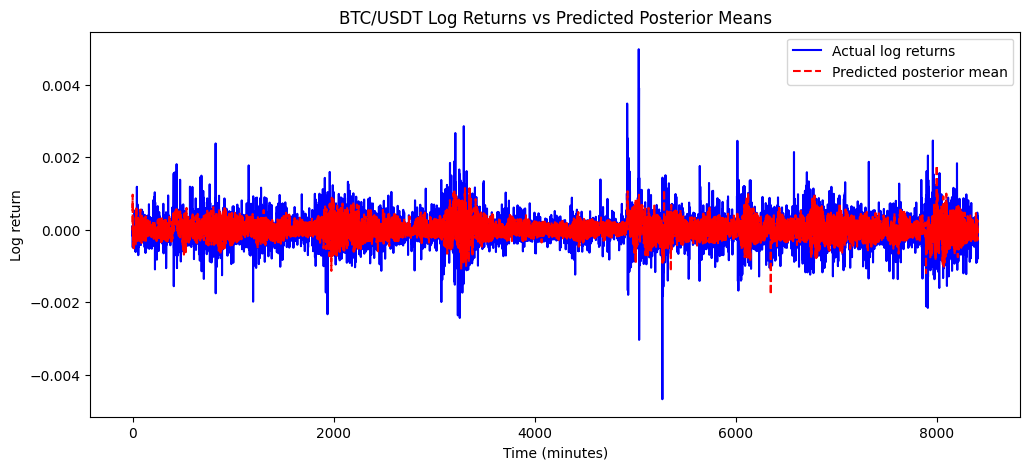

In [ ]:
def plot_prediction_means(p):

    y = df["log_return"].to_numpy()
    plt.figure(figsize=(12, 5))
    plt.plot(y[1:], label="Actual log returns", color="blue")
    plt.plot(mean[1:], label="Predicted posterior mean", color="red", linestyle="--")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Log return")
    plt.title("BTC/USDT Log Returns vs Predicted Posterior Means")
    plt.legend()
    filename = f"regression_post_mean.png"
    file_path = os.path.join("../figures/", filename)
    plt.savefig(file_path, format='png')
    plt.show()

plot_prediction_means(100)

In [ ]:
def count_correct_ppi(p):
    # _, lb, ub = get_predictions(p)
    y = df["log_return"].to_numpy()
    count = 0
    for i in range(len(mean)):
        if y[i] >= lb[i] and y[i] <= ub[i]:
            count += 1

    print(100 * count / len(mean))

count_correct_ppi(100)


99.96432818073721
